**Models**:
- Logistic Regression (LR)
- Random Forest (RF)
- Neural Network (NN)

# Table of Contents

>[Table of Contents](#scrollTo=1vIrrlI5qYYy)

>[Load Packages](#scrollTo=7kYT-Av0M30Y)

>[Load Datasets and Basic Data Cleaning](#scrollTo=W8j2Yk93M30a)

>>[BC & RF: features dataset](#scrollTo=ogBM3dkMM30a)

>>[NN: sites_data.csv](#scrollTo=XsGpGZJoM30b)

>>[All: Pollution Data](#scrollTo=iAjdKpWAM30b)

>[Data Manipulation and Further Data Cleaning](#scrollTo=7jfpVEdhM30b)

>>>[BC & RF: Replace NaNs with mean](#scrollTo=2tNYFCXyM30b)

>>>[BC & RF: Replace NaNs with -10](#scrollTo=w2nMfJ_MM30c)

>[Train-Test Split](#scrollTo=k5Rh25eDM30d)

>>[5-fold CV on Training Data](#scrollTo=NVfVZtslVDgN)

>[Train & Test Models](#scrollTo=LqVCHBwqM30d)

>>[Baseline](#scrollTo=WCq5OTnjM30d)

>>[BC](#scrollTo=fCm5MtmEM30d)

>>>[df_merged_mean](#scrollTo=sk2ahJhvM30d)

>>>>[ROC](#scrollTo=AUtGhFBxM30f)

>>>[df_merged_neg](#scrollTo=LbH3oq34M30f)

>>[RF](#scrollTo=tX_m83LwM30g)

>>>[df_merged_mean](#scrollTo=WwjWWDddM30g)

>>>>[Importance of Feature Aggregation](#scrollTo=HSd3THghM30h)

>>>>[PCA](#scrollTo=ce8UQqnCM30h)

>>>[df_merged_neg](#scrollTo=yNtOjtXHM30h)

>>>>[Importance of Feature Aggregation](#scrollTo=d85180_iM30i)

>>>>[PCA](#scrollTo=3iz1OD5WM30i)

>>[NN](#scrollTo=HqmPxsTQM30j)

>>>[Helper Functions](#scrollTo=kweB7fnOM30j)

>>>[Training Models](#scrollTo=42b7DOTtM30k)

>>>>[Training From Scratch](#scrollTo=orGBi9j_QSm6)

>>>>>[With Cross Validation (Takes up too much RAM)](#scrollTo=CQ2WRerRdX5E)

>>>>>[Save Model](#scrollTo=VY6Q610dder6)

>>>>[Training From Existing Model](#scrollTo=7_MflnfHQXCz)

>>>>>[Load Model From File](#scrollTo=qbDjSSIaoPmH)

>>>>>[Training](#scrollTo=um8esTkeoRAe)

>[Final Results](#scrollTo=KCRcg5wRM30k)

>[Window Size Comparison](#scrollTo=MhySSdKwM30l)

>>[BC](#scrollTo=_xgmshK1M30l)

>>[RF](#scrollTo=kiYFhCJiM30l)

>>[NN](#scrollTo=Y54BwAv-M30l)

>[Accuracy Comparison](#scrollTo=yw0R9N0gM30m)

>>[NN](#scrollTo=OZhXFnbPM30m)



# &nbsp; Load Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras import backend as K

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from datetime import datetime
from keras.optimizers import Adam
import itertools
from IPython.display import clear_output
import pickle
from collections import defaultdict
import random
import gc
from csv import writer

In [ ]:
tf.test.gpu_device_name()

# Data Cleaning (REDUNDANT)

## BC & RF: features dataset

In [ ]:
%%time
df_feature = pd.read_csv('/content/drive/My Drive/CapstoneProject/Datasets/feature_extraction_51x51.csv')
df_feature = df_feature.dropna(how='all', subset=df_feature.columns[2:])
df_feature

,time,site,TUR_1x1_median,SPM_1x1_median,CHL_1x1_median,TUR_1x1_mean,SPM_1x1_mean,CHL_1x1_mean,TUR_1x1_q1,SPM_1x1_q1,...,CHL_51x51_median,TUR_51x51_mean,SPM_51x51_mean,CHL_51x51_mean,TUR_51x51_q1,SPM_51x51_q1,CHL_51x51_q1,TUR_51x51_q3,SPM_51x51_q3,CHL_51x51_q3
0,2020-01-04,ukf3102-09100,108.93730,82.804050,9.694109,108.93730,82.804050,9.694109,108.93730,82.804050,...,7.786972,56.991574,39.174789,8.061594,43.640497,28.339942,6.656758,61.104443,41.905066,9.190117
1,2020-01-04,ukf3102-09200,116.36637,92.065480,9.894425,116.36637,92.065480,9.894425,116.36637,92.065480,...,8.937684,64.657951,45.736671,9.018375,49.536735,32.876476,7.464715,68.959285,48.319313,10.118837
2,2020-01-04,ukf3102-09400,107.69669,86.643550,13.944178,107.69669,86.643550,13.944178,107.69669,86.643550,...,9.186992,69.629040,49.706337,9.381335,60.110758,41.077278,8.235911,73.797290,53.108590,10.310409
3,2020-01-04,ukf3102-09600,157.11348,131.455100,14.738614,157.11348,131.455100,14.738614,157.11348,131.455100,...,8.160086,52.962076,37.057555,8.556871,38.118608,24.710560,7.108883,63.412932,44.594133,9.660246
4,2020-01-04,ukf3102-09700,117.12625,93.854904,12.754065,117.12625,93.854904,12.754065,117.12625,93.854904,...,7.084467,31.324775,20.877057,7.982920,17.733513,10.922977,6.416773,34.601340,22.003967,8.369608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113421,2022-11-28,ukk3101-26530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.410271,3.176707,1.859303,2.536886,2.869820,1.673176,2.258490,3.312921,1.941688,2.688667
113422,2022-12-07,ukk4200-23200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.443477,10.726367,6.459139,8.443477,10.726367,6.459139,8.443477,10.726367,6.459139,8.443477
113423,2022-12-07,ukk4306-23000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.248995,6.791190,4.061143,5.279060,6.673853,3.990707,5.188523,6.821655,4.078659,5.339532
113424,2022-12-17,ukc2103-04600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.037140,23.244257,14.438895,8.037140,23.233103,14.434131,7.982498,23.255411,14.443659,8.091781


## All: Pollution Data

In [ ]:
riskforecasting = pd.read_csv('/content/drive/My Drive/CapstoneProject/Datasets/prf.csv')
riskforecasting["riskLevelLabel"].replace({"normal": 0, "increased": 1}, inplace=True)
riskforecasting['time'] = pd.to_datetime(riskforecasting['predictedAt']).dt.strftime('%Y-%m-%d')
riskforecasting.drop(['label', 'predictedAt', 'publishedAt', 'expiresAt', 'warning'], axis=1, inplace=True)
riskforecasting.rename({'EUBWID':'site'}, axis=1, inplace=True)
riskforecasting = riskforecasting[riskforecasting['riskLevelLabel'] != 'no-prediction']
riskforecasting

NameError: ignored

In [ ]:
# riskforecasting = pd.read_csv('/content/drive/My Drive/CapstoneProject/Datasets/pollution_risk_forecasting.csv')
# riskforecasting["riskLevelLabel"].replace({"normal": 0, "increased": 1}, inplace=True)
# riskforecasting

<Axes: xlabel='riskLevelLabel'>

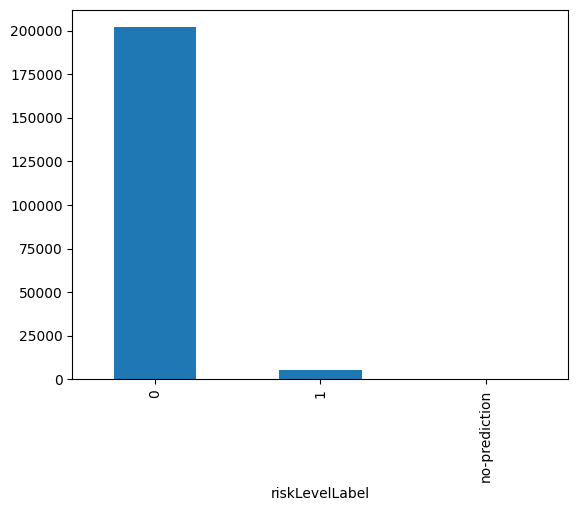

In [ ]:
riskforecasting.groupby(['riskLevelLabel']).size().plot(kind = "bar")

## BC & RF: Replace NaNs with mean

In [ ]:
%%time
def fill_na_values_with_mean(row, feature, dimensions):
    if pd.isnull(row).any():
        for dim in dimensions:
            if pd.isna(row[f"{feature}_{dim}x{dim}_median"]):
                available_medians = row[[f"{feature}_{i}x{i}_median" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_median"])]]
                row[f"{feature}_{dim}x{dim}_median"] = available_medians.mean()

            if pd.isna(row[f"{feature}_{dim}x{dim}_mean"]):
                available_means = row[[f"{feature}_{i}x{i}_mean" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_mean"])]]
                row[f"{feature}_{dim}x{dim}_mean"] = available_means.mean()

            if pd.isna(row[f"{feature}_{dim}x{dim}_q1"]):
                available_q1s = row[[f"{feature}_{i}x{i}_q1" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_q1"])]]
                row[f"{feature}_{dim}x{dim}_q1"] = available_q1s.mean()

            if pd.isna(row[f"{feature}_{dim}x{dim}_q3"]):
                available_q3s = row[[f"{feature}_{i}x{i}_q3" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_q3"])]]
                row[f"{feature}_{dim}x{dim}_q3"] = available_q3s.mean()
    return row

# apply the function to the DataFrame
dimensions = range(1, 52, 2)
df_feature_mean = df_feature
for feature in ["TUR", "SPM", "CHL"]:
    df_feature_mean = df_feature_mean.apply(fill_na_values_with_mean, axis=1, args=(feature, dimensions))

CPU times: user 34min 26s, sys: 25.7 s, total: 34min 52s
Wall time: 35min 24s


In [ ]:
df_feature_mean.to_csv('/content/drive/My Drive/CapstoneProject/Datasets/df_feature_mean.csv')

In [ ]:
df_feature_mean = pd.read_csv('/content/drive/My Drive/CapstoneProject/Datasets/df_feature_mean.csv')

In [ ]:
df_feature_mean.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
%%time
df_merged_mean = pd.merge(df_feature_mean, riskforecasting[['site', 'time', 'riskLevelLabel']], on=['site', 'time'])
scaler = MinMaxScaler()
df_merged_mean.iloc[:, 2:-1] = scaler.fit_transform(df_merged_mean.iloc[:, 2:-1])
df_merged_mean

CPU times: user 2.1 s, sys: 446 ms, total: 2.54 s
Wall time: 2.53 s


,time,site,TUR_1x1_median,SPM_1x1_median,CHL_1x1_median,TUR_1x1_mean,SPM_1x1_mean,CHL_1x1_mean,TUR_1x1_q1,SPM_1x1_q1,...,TUR_51x51_mean,SPM_51x51_mean,CHL_51x51_mean,TUR_51x51_q1,SPM_51x51_q1,CHL_51x51_q1,TUR_51x51_q3,SPM_51x51_q3,CHL_51x51_q3,riskLevelLabel
0,2020-05-14,ukc1101-06200,0.003353,0.002278,0.085167,0.003597,0.002459,0.077724,0.003068,0.002063,...,0.018797,0.012889,0.044697,0.008177,0.005117,0.141128,0.012809,0.008143,0.125191,0
1,2020-05-14,ukc1202-06300,0.010242,0.007866,0.092883,0.010242,0.007866,0.082441,0.009130,0.006856,...,0.021473,0.015833,0.037429,0.006774,0.004229,0.125526,0.008685,0.005510,0.099624,0
2,2020-05-14,ukc1202-06400,0.003802,0.002574,0.077630,0.003802,0.002574,0.068848,0.003010,0.002025,...,0.018753,0.013767,0.035812,0.006623,0.004136,0.120844,0.007714,0.004873,0.095733,0
3,2020-05-14,ukc1202-06650,0.011083,0.008029,0.084412,0.011083,0.008029,0.074892,0.008832,0.006244,...,0.024545,0.019170,0.033204,0.005784,0.003617,0.102302,0.008237,0.005199,0.096264,0
4,2020-05-14,ukc1202-06700,0.022875,0.017259,0.110698,0.022875,0.017259,0.098318,0.022875,0.017259,...,0.020761,0.016375,0.033749,0.005829,0.003635,0.108741,0.007108,0.004506,0.090818,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52282,2022-09-08,ukk4306-23000,0.000396,0.000274,0.003743,0.000396,0.000274,0.002996,0.000395,0.000274,...,0.001728,0.001144,0.001030,0.002964,0.001845,0.010635,0.001729,0.001085,0.003384,0
52283,2022-09-18,ukk4200-23800,0.000782,0.000531,0.017944,0.000782,0.000531,0.015653,0.000782,0.000531,...,0.004484,0.002884,0.008886,0.005777,0.003629,0.039473,0.004044,0.002567,0.022747,0
52284,2022-09-23,ukk4200-23100,0.000693,0.000471,0.012495,0.000693,0.000471,0.010796,0.000693,0.000471,...,0.003851,0.002480,0.005871,0.005131,0.003215,0.028820,0.003512,0.002222,0.015017,0
52285,2022-09-28,ukj4208-13300,0.027412,0.026219,0.078874,0.027412,0.026219,0.069955,0.026206,0.025889,...,0.194465,0.176820,0.042594,0.190732,0.179347,0.134177,0.170988,0.152809,0.126878,0


In [ ]:
df_merged_mean.to_csv('/content/drive/My Drive/CapstoneProject/Datasets/df_merged_mean_new.csv')

## BC & RF: Replace NaNs with -10

In [ ]:
df_feature_neg = df_feature
df_feature_neg.fillna(value=-10, inplace=True)

NameError: ignored

In [ ]:
df_merged_neg = pd.merge(df_feature_neg, riskforecasting[['site', 'time', 'riskLevelLabel']], on=['site', 'time'])
df_merged_neg.iloc[:, 2:-1] = scaler.fit_transform(df_merged_neg.iloc[:, 2:-1])
df_merged_neg

In [ ]:
df_merged_neg.to_csv('/content/drive/My Drive/CapstoneProject/Datasets/df_merged_neg_new.csv')

# Load Cleaned Datasets

## NN: sites_data.csv

In [ ]:
sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51.pkl")
sites_data

,time,site,TUR,SPM,CHL,riskLevelLabel
0,2020-02-29,ukk4304-34200,"[[-0.9811192569131857, -0.9795547499650448, -0...","[[0.524045278902291, 0.5756248475971223, 0.560...","[[0.34057330828591803, 0.370465598289415, 0.34...",1
1,2020-03-12,uke1200-08100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,2020-05-14,ukc1101-06000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,2020-05-14,ukc1101-06100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,2020-05-14,ukc1101-06200,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.401122631769...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.27785837711...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.24223761712...",0
...,...,...,...,...,...,...
52282,2022-09-30,ukj4210-12750,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
52283,2022-09-30,ukj4210-12800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
52284,2022-09-30,ukj4210-12850,"[[1.5549465060235468, 1.5557287594976177, 1.55...","[[1.5127710419438254, 2.94540271916225, 2.7731...","[[1.5251629301217988, 3.2531680809087082, 2.70...",0
52285,2022-09-30,ukj4210-12900,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5525997...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9585223...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8346373...",0


In [ ]:
sites_data.isnull().sum()

time              0
site              0
TUR               0
SPM               0
CHL               0
riskLevelLabel    0
dtype: int64

# Train-Test Split
- Pick time-site pairs to use as train data and test data
- Potential for implementing cross validation

In [ ]:
time_site_pairs = sites_data[['time', 'site']]

# 80/20 split
time_site_pairs_test = time_site_pairs.sample(frac=.2, random_state=42)
time_site_pairs_test

,time,site
35915,2022-05-21,ukk4200-23501
22922,2021-06-25,ukk2302-35600
30578,2021-09-05,ukh1305-10125
13905,2020-09-13,ukh1305-10200
21006,2021-06-08,ukk2204-20200
...,...,...
940,2020-05-21,ukh1303-10650
48385,2022-09-01,ukk3106-27800
41547,2022-07-08,ukk4305-25100
30727,2021-09-06,ukk1202-35700


In [ ]:
time_site_pairs_train = time_site_pairs[~time_site_pairs.isin(time_site_pairs_test)].dropna()
time_site_pairs_train = time_site_pairs_train.sample(frac=1, random_state=42)
time_site_pairs_train

,time,site
1964,2020-05-28,ukj4210-12300
13028,2020-09-05,ukh1407-10830
12136,2020-08-27,ukk3106-32300
20217,2021-06-03,ukd5400-40900
32291,2021-09-18,ukj2402-15500
...,...,...
7872,2020-07-20,ukj3400-17800
14125,2020-09-14,ukk3102-31700
47704,2022-08-27,ukk4304-34100
1083,2020-05-21,ukk2205-21500


In [ ]:
# time_site_pairs_test.to_csv("time_site_pairs_test.csv")
# time_site_pairs_train.to_csv("time_site_pairs_train.csv")

## 5-fold CV on Training Data

In [ ]:
# Randomise order of training pairs
time_site_pairs_train_new = time_site_pairs_train.sample(frac = 1)

train_test_dict = {}

# Get CV Train and Test time-site pairs
for i in range(5):
  split_index = round(len(time_site_pairs_train_new)/5)
  train_test_dict[f'test_{i+1}'] = time_site_pairs_train_new[i*split_index: (i+1)*split_index]
  train_test_dict[f'train_{i+1}'] = time_site_pairs_train_new.drop(time_site_pairs_train_new.index[i*split_index: (i+1)*split_index])

# Train & Test Models
- Train on training time-site pairs
- Test on testing time-site pairs

## Baseline

In [ ]:
import random
time_site_pairs_train_new = time_site_pairs_train.sample(frac = 1)

In [ ]:
b_accuracy_test_sum=0
b_precision_test_sum=0
b_recall_test_sum=0
b_f1_test_sum=0
b_auc_test_sum=0

for i in range(5):
    print(i+1,':')
    test_d = train_test_dict[f'test_{i+1}']
    train_d = train_test_dict[f'train_{i+1}']

    df_train = df_merged_mean.merge(train_d, on=['time', 'site'], how='inner')
    df_test = df_merged_mean.merge(test_d, on=['time', 'site'], how='inner')

    df_train.drop(['time', 'site'], axis=1, inplace=True)
    df_test.drop(['time', 'site'], axis=1, inplace=True)

    y_train = df_train.pop('riskLevelLabel')
    y_test = df_test.pop('riskLevelLabel')

    X_train = df_train
    X_test = df_test

    label_ratio_train = y_train.value_counts(normalize=True).to_dict()
    num_test_samples = len(X_test)
    random_predictions_test = np.random.choice(list(label_ratio_train.keys()), num_test_samples, p=list(label_ratio_train.values()))

    accuracy_test = np.mean(random_predictions_test == y_test)
    print(f'Accuracy of baseline on test set: {accuracy_test:.2%}')
    precision_test = precision_score(y_test, random_predictions_test)#, average='weighted')
    recall_test = recall_score(y_test, random_predictions_test)#, average='weighted')
    f1_test = f1_score(y_test, random_predictions_test)#, average='weighted')

    print(f'Precision of baseline on test set: {precision_test:.2%}')
    print(f'Recall of baseline on test set: {recall_test:.2%}')
    print(f'F1-score of baseline on test set: {f1_test:.2%}')
    if len(label_ratio_train.keys()) == 2:
        lb = LabelBinarizer()
        test_data_bin = lb.fit_transform(y_test)
        random_predictions_test_bin = lb.transform(random_predictions_test)
        auc_test = roc_auc_score(test_data_bin, random_predictions_test_bin)
        print(f'AUC of baseline on test set: {auc_test:.2%}')

    print("Confusion matrix:\n", confusion_matrix(y_test, random_predictions_test))

    b_accuracy_test_sum += accuracy_test
    b_precision_test_sum += precision_test
    b_recall_test_sum += recall_test
    b_f1_test_sum += f1_test
    b_auc_test_sum += auc_test

1 :
Accuracy of baseline on test set: 95.14%
Precision of baseline on test set: 0.00%
Recall of baseline on test set: 0.00%
F1-score of baseline on test set: 0.00%
AUC of baseline on test set: 48.95%
Confusion matrix:
 [[2798   60]
 [  83    0]]
2 :
Accuracy of baseline on test set: 95.46%
Precision of baseline on test set: 1.37%
Recall of baseline on test set: 1.54%
F1-score of baseline on test set: 1.45%
AUC of baseline on test set: 49.54%
Confusion matrix:
 [[2856   72]
 [  64    1]]
3 :
Accuracy of baseline on test set: 95.06%
Precision of baseline on test set: 2.50%
Recall of baseline on test set: 2.90%
F1-score of baseline on test set: 2.68%
AUC of baseline on test set: 50.09%
Confusion matrix:
 [[2786   78]
 [  67    2]]
4 :
Accuracy of baseline on test set: 95.20%
Precision of baseline on test set: 1.22%
Recall of baseline on test set: 1.59%
F1-score of baseline on test set: 1.38%
AUC of baseline on test set: 49.40%
Confusion matrix:
 [[2833   81]
 [  62    1]]
5 :
Accuracy of 

In [ ]:
## Average
print(f'Accuracy of baseline on test set: {b_accuracy_test_sum/5:.2%}')
print(f'Precision of baseline on test set: {b_precision_test_sum/5:.2%}')
print(f'Recall of baseline on test set: {b_recall_test_sum/5:.2%}')
print(f'F1-score of baseline on test set: {b_f1_test_sum/5:.2%}')
print(f'AUC of baseline on test set: {b_auc_test_sum/5:.2%}')

Accuracy of baseline on test set: 95.22%
Precision of baseline on test set: 1.27%
Recall of baseline on test set: 1.54%
F1-score of baseline on test set: 1.39%
AUC of baseline on test set: 49.49%


In [ ]:
results_df_baseline = pd.DataFrame([['Baseline', b_auc_test_sum/5, b_precision_test_sum/5, b_recall_test_sum/5, b_f1_test_sum/5, b_accuracy_test_sum/5]], columns=['Model', 'AUC_roc','Precision','Recall','f1','acc'])
results_df_baseline

,Model,AUC_roc,Precision,Recall,f1,acc
0,Baseline,0.494864,0.01271,0.015382,0.013904,0.952182


In [ ]:
results_df_baseline.to_csv('')

|index|Model|AUC\_roc|Precision|Recall|f1|acc|
|---|---|---|---|---|---|---|
|0|Baseline|0\.49486446900623254|0\.012710395987261416|0\.015381961034134948|0\.013903996772797998|0\.9521824841084628|

## BC

### df_merged_mean

In [ ]:
# Train-test split
df_train = df_merged_mean.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_mean.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (14725, 313)
Training y Shape: (14725,)
Testing X Shape: (3683, 313)
Testing y Shape: (3683,)


In [ ]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# variable selection using LASSO
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train_scaled, y_train)
model = SelectFromModel(logreg, prefit=True)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

logreg_selected = LogisticRegression(max_iter=10000)
logreg_selected.fit(X_train_selected, y_train)
y_pred = logreg_selected.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9812652728753734
Confusion matrix:
 [[3610    2]
 [  67    4]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3612
           1       0.67      0.06      0.10        71

    accuracy                           0.98      3683
   macro avg       0.82      0.53      0.55      3683
weighted avg       0.98      0.98      0.97      3683



In [ ]:
def lg_model(x,y):
    lg_model = LogisticRegression(
        random_state = 100, #specify the random_state
        solver = 'saga',
        n_jobs = -1 , #use all cpu cores
        max_iter = 1000 #give more iteration for model to converge
    )

    params = {'penalty': ['l1', 'l2'],# penalty term
              'C': (0.1, 1,10)} #λ

    lg = GridSearchCV(lg_model, params, cv=5)#scoring=make_scorer(f1_score, average='macro'))
    lg.fit(x, y)
    print(lg.best_score_)
    print('Best_parameters:',lg.best_params_)
    return lg.best_estimator_

In [ ]:
%%time
base_lg = lg_model(X_train_scaled, y_train)

0.9763667232597623
Best_parameters: {'C': 0.1, 'penalty': 'l1'}
CPU times: user 1min 32s, sys: 5.29 s, total: 1min 38s
Wall time: 32min 11s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# %%time
# base_selected_lg = lg_model(X_train_selected,y_train)

Precision-Recall Curve



In [ ]:
from sklearn.metrics import precision_recall_curve
def auc_pr_curve(model, X_test, y_test):
    y_pred_prob = model.predict(X_test_scaled)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    #fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, label='Precision recall curve (area = %0.2f)' % prc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

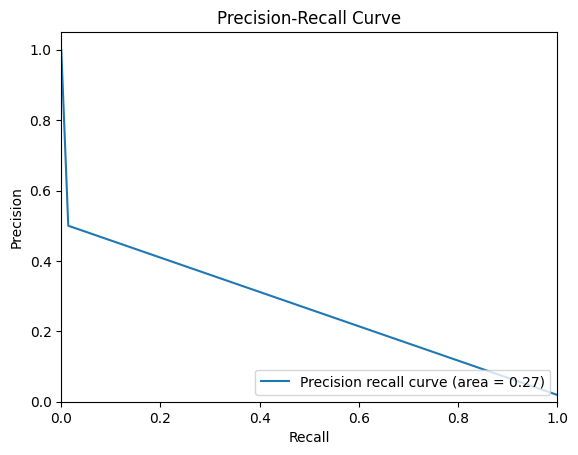

In [ ]:
auc_pr_curve(base_lg, X_test_scaled, y_test)

#### ROC

In [ ]:
def draw_roc(model,X_test,y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Curve')
    plt.legend(loc="lower right")
    plt.show()

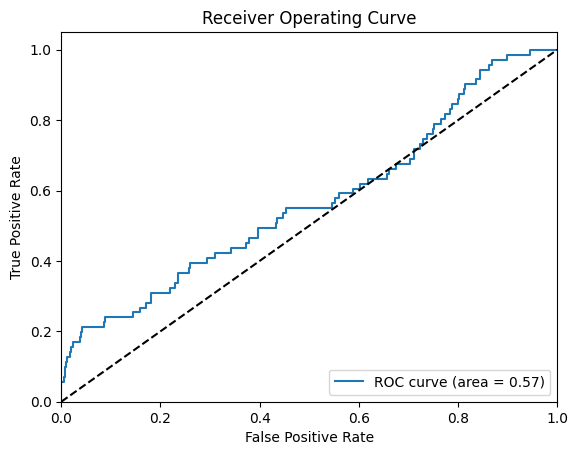

In [ ]:
draw_roc(base_lg, X_test_scaled, y_test)

In [ ]:
y_pred_prob = base_lg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
bc_auc = auc(fpr, tpr)

In [ ]:
def training_cross_validation_score(model,x,y):
    accuray_scores = cross_val_score(model,x, y, scoring='accuracy', cv=5, n_jobs=-1)# evaluate the model through 5 fold cross-validation
    auc_scores = cross_val_score(model,x, y, scoring='roc_auc', cv=5, n_jobs=-1)# evaluate the model through 5 fold cross-validation
    f1_scores = cross_val_score(model,x, y, scoring='f1', cv=5, n_jobs=-1)# evaluate the model through 5 fold cross-validation
    print(str(model),'\naccuracy:',accuray_scores, '\naverage accuray:',accuray_scores.mean())
    print('\nauc score:', auc_scores,'\naverage auc score:',auc_scores.mean())
    print('\nf1 score:',f1_scores,'\naverage f1 score:',f1_scores.mean())

In [ ]:
%%time
training_cross_validation_score(base_lg, X_train_scaled, y_train)

LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=100, solver='saga') 
accuracy: [0.97163966 0.97163628 0.97163628 0.9710404  0.97080205] 
average accuray: 0.9713509321974302

auc score: [0.56186168 0.61081253 0.59412274 0.67013782 0.55390432] 
average auc score: 0.5981678200786684

f1 score: [0. 0. 0. 0. 0.] 
average f1 score: 0.0
CPU times: user 10.6 s, sys: 1.22 s, total: 11.8 s
Wall time: 48min 48s


In [ ]:
def test_evaluation(model,x,y):
    y_pred = model.predict(x)
    print(str(model),"\nOn test data, f1 score: %.2f "%f1_score(y, y_pred))
    print("On test data, Precision: %.2f" %precision_score(y, y_pred))
    print("Recall: %.2f" %recall_score(y, y_pred))
    acc = accuracy_score(y, y_pred)
    print("Accuracy: {:.2f} %".format(acc*100))
    ConfusionMatrixDisplay.from_estimator(model, x, y)

LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=100, solver='saga') 
On test data, f1 score: 0.00 
On test data, Precision: 0.00
Recall: 0.00
Accuracy: 97.36 %


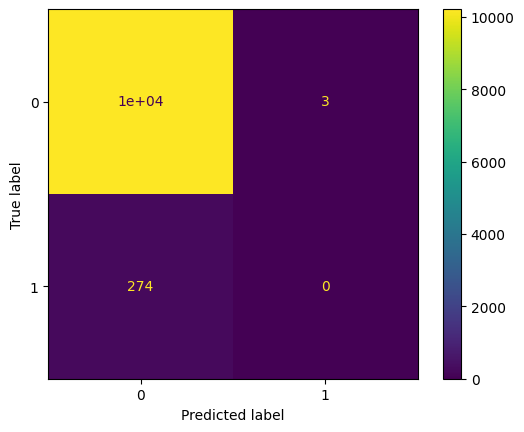

In [ ]:
test_evaluation(base_lg, X_test_scaled, y_test)

In [ ]:
y_pred = base_lg.predict(X_test_scaled)
bc_f1 = f1_score(y_test, y_pred)
bc_pre = precision_score(y_test, y_pred)
bc_rec = recall_score(y_test, y_pred)
bc_acc = accuracy_score(y_test, y_pred)

In [ ]:
results_df_bc = pd.DataFrame([['Binary Classifier', 'Fill NaN with mean df', bc_auc, bc_pre, bc_rec, bc_f1, bc_acc]], columns=['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc'])
results_df_bc

,Model,Sub-Model,AUC,Precision,Recall,f1,acc
0,Binary Classifier,Fill NaN with mean df,0.603027,0.0,0.0,0.0,0.973606


|index|Model|Sub-Model|AUC|Precision|Recall|f1|acc|
|---|---|---|---|---|---|---|---|
|0|Binary Classifier|Fill NaN with mean df|0\.5685313430973438|0\.5|0\.014084507042253521|0\.027397260273972605|0\.9807222373065436|

### df_merged_neg

In [ ]:
# # Train-test split
# df_train = df_merged_neg.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
# df_test = df_merged_neg.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

# df_train.drop(['time', 'site'], axis=1, inplace=True)
# df_test.drop(['time', 'site'], axis=1, inplace=True)

# y_train = df_train.pop('riskLevelLabel')
# y_test = df_test.pop('riskLevelLabel')

# X_train = df_train
# X_test = df_test

# print('Training X Shape:', X_train.shape)
# print('Training y Shape:', y_train.shape)
# print('Testing X Shape:', X_test.shape)
# print('Testing y Shape:', y_test.shape)

In [ ]:
# # feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # variable selection using LASSO
# logreg = LogisticRegression(penalty='l1', solver='liblinear')
# logreg.fit(X_train_scaled, y_train)
# model = SelectFromModel(logreg, prefit=True)
# X_train_selected = model.transform(X_train_scaled)
# X_test_selected = model.transform(X_test_scaled)

# logreg_selected = LogisticRegression(max_iter=10000)
# logreg_selected.fit(X_train_selected, y_train)
# y_pred = logreg_selected.predict(X_test_selected)

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification report:\n", classification_report(y_test, y_pred))

In [ ]:
# %%time
# neg_lg = lg_model(X_train_scaled,y_train)

In [ ]:
# #scaling - based on training data
# mean_train = X_train.mean() #compute the mean of training set
# train_std = X_train.std() #compute the std of training set
# scaled_X_train = (X_train-mean_train)/train_std
# scaled_X_test = (X_test-mean_train)/train_std # to avoid bias, use the mean and std from training dataset and apply it on the testing dataset.

In [ ]:
# draw_roc(base_lg, scaled_X_test, y_test)

In [ ]:
# %%time
# training_cross_validation_score(base_lg, X_train_scaled,y_train)

In [ ]:
# test_evaluation(base_lg, scaled_X_test, y_test)

## RF

In [ ]:
df_merged_mean = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/df_merged_mean_new.csv")
df_merged_neg = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/df_merged_neg_new.csv")
time_site_pairs_train = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_train.csv")
time_site_pairs_test = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_test.csv")

<ipython-input-5-701f378bd31b>:2: DtypeWarning: Columns (315) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged_neg = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/df_merged_neg_new.csv")


### df_merged_mean

In [ ]:
# Train-test split
df_train = df_merged_mean.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_mean.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (14750, 314)
Training y Shape: (14750,)
Testing X Shape: (3658, 314)
Testing y Shape: (3658,)


In [ ]:
def rf_result(X_train, y_train, X_test, y_test):
    # fit a random forest to the data
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # make predictions
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = np.mean(y_pred == y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    return {'Classifier': rf,
            'Precision': precision,
            'Recall': recall,
            'f1': f1,
            'acc': accuracy,
            'AUC': auc}

In [ ]:
res = rf_result(X_train, y_train, X_test, y_test)
res['Model'] = 'Random Forest'
res['Sub-Model'] = 'Fill NaN with mean df'
results_df_rf = pd.DataFrame([res]).drop(columns = ['Classifier'])

#### Importance of Feature Aggregation

In [ ]:
rf = res['Classifier']

In [ ]:
importance_dict = dict(zip(df_train.columns, rf.feature_importances_))

features = [f'{i}x{i}' for i in range(51, 0, -2)] + ['TUR', 'SPM', 'CHL']

data = []
for s in features:
    sum_importance = np.sum([importance for feature, importance in importance_dict.items() if s in feature])
    data.append([s, sum_importance])

# Create a DataFrame with the calculated data
df_importances = pd.DataFrame(data, columns=['Feature', 'Sum of Importances'])

def highlight_max(s):
    if len(s) > 3:
        return ['background-color: #DEB887' if v in list(s[np.argsort(s)[-3:]]) else '' for v in s]
    else:
        return ['background-color: #8FBC8F' if v == s.max() else '' for v in s]

df_importances[:26].style.apply(highlight_max, subset=['Sum of Importances'])

,Feature,Sum of Importances
0,51x51,0.035796
1,49x49,0.035292
2,47x47,0.031613
3,45x45,0.030387
4,43x43,0.032311
5,41x41,0.032708
6,39x39,0.027554
7,37x37,0.032819
8,35x35,0.028719
9,33x33,0.031239


In [ ]:
df_importances[-3:].style.apply(highlight_max, subset=['Sum of Importances'])

,Feature,Sum of Importances
26,TUR,0.299257
27,SPM,0.313937
28,CHL,0.357934


#### PCA

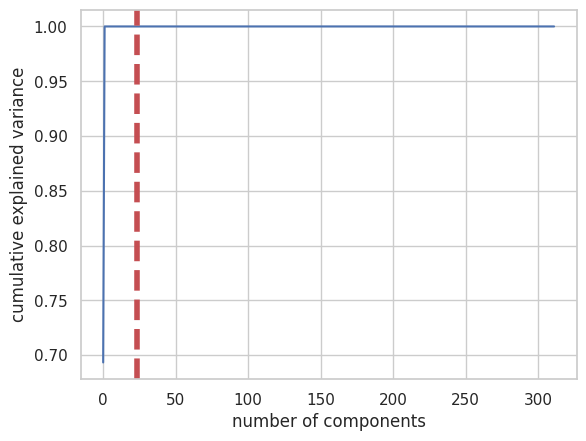

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.693328,6.933276e-01
1,1.000000,3.066724e-01
2,1.000000,1.071976e-09
3,1.000000,2.789317e-10
4,1.000000,4.389508e-11
5,1.000000,2.480093e-11
6,1.000000,1.395056e-11
7,1.000000,9.661991e-12
8,1.000000,8.213648e-12
9,1.000000,6.567685e-12


In [ ]:
pca_test = PCA(n_components=312)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=23, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(25))

In [ ]:
pca = PCA(n_components=23)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=df_train.columns, index=pca_dims)
pca_test_df.head(23).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,...,PCA Component 13,PCA Component 14,PCA Component 15,PCA Component 16,PCA Component 17,PCA Component 18,PCA Component 19,PCA Component 20,PCA Component 21,PCA Component 22
Unnamed: 0_x,-7.142339e-02,-9.974461e-01,-0.000002,-0.000006,5.308949e-06,5.107361e-07,6.822974e-06,-2.747065e-06,3.494996e-06,1.565759e-06,...,3.845288e-07,5.002670e-07,-8.915657e-07,-1.085729e-06,1.295745e-06,-2.427477e-07,-3.852184e-08,-6.986055e-08,-3.237396e-07,3.753755e-07
TUR_1x1_median,1.355474e-06,2.823111e-06,0.057264,0.052007,1.115138e-01,5.501018e-02,3.190667e-01,-1.282715e-01,-2.473342e-02,-9.540200e-03,...,-2.166651e-02,9.896721e-03,2.870310e-03,3.480156e-02,-1.140404e-03,-3.989972e-03,-1.568599e-02,-6.019474e-02,2.234262e-03,-7.292133e-03
SPM_1x1_median,1.034295e-06,2.244330e-06,0.047050,0.048716,1.037453e-01,5.840578e-02,2.856998e-01,-1.239372e-01,-2.429309e-02,-4.795281e-03,...,-3.049000e-02,-2.207993e-03,1.153218e-02,3.223815e-02,-7.863907e-03,-2.864876e-02,3.547044e-02,5.936819e-02,2.622004e-02,6.860305e-03
CHL_1x1_median,1.270862e-06,2.106393e-06,0.025121,-0.027786,3.568847e-02,-6.501708e-02,5.584115e-02,2.279861e-02,1.477468e-01,2.538374e-02,...,1.931033e-01,2.339460e-01,-2.987438e-01,-6.637445e-02,2.460060e-02,-3.279652e-02,-1.234350e-02,1.182666e-02,-4.392911e-02,2.127121e-03
TUR_1x1_mean,1.359127e-06,2.311304e-06,0.060035,0.054568,1.390778e-01,6.552298e-02,2.869379e-01,-1.259587e-01,-1.912856e-02,-8.630035e-03,...,2.693016e-02,-3.217279e-02,9.932261e-03,-1.438031e-02,3.933982e-03,2.838942e-02,-5.941259e-02,-2.219786e-02,-1.959978e-02,-3.928293e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHL_51x51_q1,3.236377e-06,-2.533542e-07,0.091737,-0.096233,-8.521893e-02,9.970002e-02,6.732611e-02,1.204096e-01,4.102930e-02,-2.002993e-02,...,9.183754e-02,7.923019e-02,1.141127e-01,-2.964783e-03,6.943247e-02,-9.038675e-03,-6.133932e-03,5.172623e-03,-2.969112e-02,-8.677104e-02
TUR_51x51_q3,1.000696e-06,-8.676781e-07,0.066416,0.050560,-5.164510e-02,-2.511393e-02,9.972016e-03,1.352669e-03,-1.527491e-03,3.094786e-02,...,5.708932e-02,-4.287742e-03,-2.893348e-03,9.557480e-02,-1.562288e-02,-7.743949e-03,4.774533e-02,-1.218576e-01,2.220605e-02,6.001024e-02
SPM_51x51_q3,7.290006e-07,-7.308333e-07,0.054416,0.048843,-4.544989e-02,-2.813029e-02,4.259513e-03,-2.304386e-03,-7.370783e-03,3.332017e-02,...,4.528337e-02,-8.549172e-03,-7.329564e-03,6.997114e-02,-1.376103e-02,-5.135400e-02,9.086979e-02,6.969966e-03,5.864335e-02,6.141205e-02
CHL_51x51_q3,2.835582e-06,2.120207e-08,0.074066,-0.078832,-2.050285e-02,5.653592e-02,-3.476776e-02,-8.716921e-02,6.811194e-02,1.157182e-01,...,-2.398245e-02,-8.826040e-02,-1.088095e-01,2.567385e-03,-2.338449e-02,3.293701e-02,-3.283723e-02,2.559927e-02,3.696287e-02,5.794996e-03


In [ ]:
res = rf_result(X_train_pca, y_train, X_test_pca, y_test)
res['Model'] = 'Random Forest'
res['Sub-Model'] = 'Fill NaN with mean PCA df'
results_df_rf.loc[len(results_df_rf)] = res

### df_merged_neg

In [ ]:
# Train-test split
df_train = df_merged_neg.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_neg.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (14750, 314)
Training y Shape: (14750,)
Testing X Shape: (3658, 314)
Testing y Shape: (3658,)


In [ ]:
df_merged_neg['riskLevelLabel'] = df_merged_neg['riskLevelLabel'].replace({'1': 1, '0': 0})
df_merged_neg.drop(df_merged_neg[df_merged_neg['riskLevelLabel'] == 'no-prediction'].index, inplace=True)

In [ ]:
df_merged_neg.riskLevelLabel.unique()

array([0, 1], dtype=object)

In [ ]:
df_merged_neg['riskLevelLabel'] = pd.to_numeric(df_merged_neg['riskLevelLabel'])

In [ ]:
df_merged_neg.to_csv('df_merged_neg_new.csv', index=False)

In [ ]:
y_test.unique()

array([0, 1], dtype=object)

In [ ]:
res = rf_result(X_train, y_train, X_test, y_test)
res['Model'] = 'Random Forest'
res['Sub-Model'] = 'Fill NaN with -10 df'
results_df_rf.loc[len(results_df_rf)] = res

In [ ]:
results_df_rf

,Precision,Recall,f1,acc,AUC,Model,Sub-Model
0,0.428571,0.075949,0.129032,0.977857,0.781774,Random Forest,Fill NaN with mean df
1,0.416667,0.063291,0.109890,0.977857,0.781942,Random Forest,Fill NaN with -10 df


In [ ]:
results_df_rf.to_csv('results_df_rf.csv', index=False)

#### Importance of Feature Aggregation

In [ ]:
rf = res['Classifier']

In [ ]:
importance_dict = dict(zip(df_train.columns, rf.feature_importances_))

data = []
for s in features:
    sum_importance = np.sum([importance for feature, importance in importance_dict.items() if s in feature])
    data.append([s, sum_importance])

# Create a DataFrame with the calculated data
df_importances = pd.DataFrame(data, columns=['Feature', 'Sum of Importances'])
df_importances[:6].style.apply(highlight_max, subset=['Sum of Importances'])

,Feature,Sum of Importances
0,51x51,0.040612
1,49x49,0.039567
2,47x47,0.034799
3,45x45,0.035452
4,43x43,0.034526
5,41x41,0.034228


In [ ]:
df_importances[-3:].style.apply(highlight_max, subset=['Sum of Importances'])

,Feature,Sum of Importances
26,TUR,0.303061
27,SPM,0.315086
28,CHL,0.356870


In [ ]:
results_df_rf

,Precision,Recall,f1,acc,AUC,Model,Sub-Model
0,0.428571,0.075949,0.129032,0.977857,0.781774,Random Forest,Fill NaN with mean df
1,0.416667,0.063291,0.109890,0.977857,0.781942,Random Forest,Fill NaN with -10 df


## NN

### Helper Functions

#### Reshaping Data as Tensors

In [ ]:
def get_train_test_val_nn(input_data, train_labels, test_labels, dim = 51, oversampling = False, desired_pos_ratio =  0.5, train_val_ratio = 0.8):
    '''
    Gets train, test and validation datasets for a neural network model.

    input:
        - input_data (pd.DataFrame):
            - dataframe of shape (m, n)
            - number of datapoints = m
            - features to consider = n-1
            - one of the columns = 'riskLevelLabel'

        - train_labels / test_labels (pd.DataFrame):
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for train/test data

        - oversampling (boolean):
            - Whether oversampling should be performed

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_val_ratio (float):
            - ratio of training data to validation data

    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    '''
    train = pd.merge(train_labels, input_data, on=['time', 'site'])
    test = pd.merge(test_labels, input_data, on=['time', 'site'])

    # Changing window size
    # w = int((dim-1)/2)

    # def get_windowed_data(row):
    #     indices = np.array(range(1,122)).reshape(11,11)[5-w:6+w, 5-w:6+w].flatten()
    #     indices = [i-1 for i in indices]
    #     values = row.flatten()[[indices]].reshape(dim,dim)
    #     return values

    # if dim != 51:
    #     train['CHL'] = train['CHL'].apply(get_windowed_data)
    #     train['TUR'] = train['TUR'].apply(get_windowed_data)
    #     train['SPM'] = train['SPM'].apply(get_windowed_data)
    #     test['CHL'] = test['CHL'].apply(get_windowed_data)
    #     test['TUR'] = test['TUR'].apply(get_windowed_data)
    #     test['SPM'] = test['SPM'].apply(get_windowed_data)

    # Getting X and y
    features_column_names = list(input_data.columns)
    for x in ['riskLevelLabel', 'time', 'site']:
        features_column_names.remove(x)

    X_train, X_test = train[features_column_names], test[features_column_names]
    y_train = train['riskLevelLabel']
    y_test = test['riskLevelLabel']

    # Train Validation Split
    i = int(X_train.shape[0] * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]

    # Oversampling for training data
    if oversampling:
        # Counting number of samples to oversample
        num_positives, num_negatives = sum(y_train), len(y_train)-sum(y_train)
        num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives

        # Oversampling
        ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    X_dfs = []
    for X_df in [X_train, X_test, X_val]:

        # Reshape and Convert to Tensor
        if X_df.shape[1] == 1:
            X_df = np.array([i for i in X_df[features_column_names[0]]])
            X_df = tf.convert_to_tensor(X_df)
            X_df = tf.expand_dims(X_df, axis=3, name=None)
        else:
            X_df = np.stack([np.stack(X_df[col].values) for col in X_df.columns], axis=1)
            X_df = np.transpose(X_df, (0, 2, 3, 1))
            X_df = tf.convert_to_tensor(X_df)

        # Padding
#         X_df = tf.pad(X_df, [[0, 0], [16-w,15-w], [16-w,15-w], [0,0]])

        # Append
        X_dfs.append(X_df)

    X_train, X_test, X_val = X_dfs

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    y_val = y_val.astype('float32')

    return {'X_train': X_train,
            'X_test': X_test,
            'X_val': X_val,
            'y_train': y_train,
            'y_test': y_test,
            'y_val': y_val}

In [ ]:
# Custom F1 Score

from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# custom loss function
def wbce_custom(weight1_=30):

    def wbce(y_true, y_pred, weight1=weight1_, weight0=1.):

        tf.cast(y_true, tf.float32)
        tf.cast(y_pred, tf.float32)
        logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )

        return K.mean(logloss, axis=-1)

    return wbce

#### Fitting NN Model (Model Specifications)

In [ ]:
def fit_nn(xy_data, model_type="convolution", existing_model=None, metrics=['acc','AUC','Precision','Recall', f1],
           loss=wbce_custom, optimizer='adam',
          batch_size=64, epochs=20, dropout=0.8):
    '''
    xy_data: dictionary with X_train, X_test, X_val, y_train, y_test, y_val in this order (dict)
    model_type: "baseline"/"convolution" (string)
    loss: "binary_crossentropy" (string)
    metrics: list of metrics to track. available metrics are: (list of string/function)
        - "acc"
        - "AUC"
        - "Precision"
        - "Recall"
        - f1
    '''

    # unpacking data
    X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

    # building model

    if existing_model==None:
      model = models.Sequential()

      if model_type == "baseline":
          model.add(layers.AveragePooling2D(pool_size=4, strides=4, input_shape=X_train.shape[1:]))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dense(1, activation="sigmoid"))

      elif model_type == "convolution":
          model.add(layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same', input_shape=X_train.shape[1:]))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(5, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(1, activation='sigmoid'))

      else:
          print('Model Type Undefined')

      model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
      print(model.optimizer.get_config())

    else:
      model = existing_model

    # Fit Model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[GarbageCollectorCallback()])

    # Evaluate Model
    result = model.evaluate(X_test, y_test, callbacks=[GarbageCollectorCallback()])

    for i in [X_train, X_test, X_val, y_train, y_test, y_val]:
      del i
    gc.collect()

    return model, history, result

In [ ]:
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
def run_nn(num_feature=3, model_type="convolution", batch_size=64, epochs=100,
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0001),
           existing_model = None, metrics=["f1"], dropout=0.8):

    # Getting Input Data
    if num_feature == 1:
        input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 3:
        input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

    else:
      print('Number of features Error')

    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_,
                          time_site_pairs_train,
                          time_site_pairs_test)

    # Get history and result
    model_, history, result = fit_nn(xy_data, model_type, existing_model = existing_model,
                                     batch_size=batch_size, epochs=epochs, loss=loss,
                                     optimizer=optimizer, dropout=dropout)

    # Plot
    plot_train_val_loss(history.history, metrics=metrics)

    del xy_data
    gc.collect()

    return model_, history, result

#### Plotting Functions

In [ ]:
def confusion_matrix_plot(model, num_feature=3, oversampling__=False):

    if num_feature == 1:
        input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 3:
        input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_,
                           time_site_pairs_train,
                           time_site_pairs_test,
                           oversampling = oversampling__)

    X_test = xy_data['X_test']
    y_test = xy_data['y_test']

    preds = model.predict(X_test)
    y_pred = np.where(preds>0.5,1,0)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [ ]:
def plot_train_val_loss(his, metrics=['f1', 'precision', 'recall']):
    '''
    input:
        - history (dictionary)
        - metrics (list of strings)
    output: 2 graphs
    '''
    fig, axs = plt.subplots(len(metrics)+1, 1, figsize=(5,5+len(metrics)*2))
    fig.tight_layout(pad=5)
    axs[0].plot(his['loss'])
    axs[0].plot(his['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])

    for j, metric in enumerate(metrics):
        axs[j+1].plot(his[f'{metric}'])
        axs[j+1].plot(his[f'val_{metric}'])
        axs[j+1].title.set_text(f'Training {metric} vs Validation {metric}')
        axs[j+1].legend(['Training', 'Validation'])
        axs[j+1].set_xlabel("Epochs")
        axs[j+1].set_ylabel(f"{metric}")

In [ ]:
def get_combined_history(history_list):
  '''
  history_list (list): list of dictionaries containing histories, in order
  '''
  dd = defaultdict(list)
  all_history = {}

  for d in [old_history, history.history]:
    for key, value in d.items():
      dd[key].append(value)

  for key, value in dd.items():
      all_history[key] = [item for sublist in value for item in sublist]

  return all_history

### Training Models

#### Training From Scratch

##### Without Cross Validation

2023-06-29 11:03:21.008525
{'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Epoch 1/3
525/525 [==============================] - 15s 10ms/step - loss: 1.7048 - acc: 0.4984 - auc: 0.5347 - precision: 0.0322 - recall: 0.5573 - f1: 0.0571 - val_loss: 1.5353 - val_acc: 0.4466 - val_auc: 0.5357 - val_precision: 0.0289 - val_recall: 0.6538 - val_f1: 0.0539
Epoch 2/3
525/525 [==============================] - 5s 10ms/step - loss: 1.6775 - acc: 0.2802 - auc: 0.5472 - precision: 0.0322 - recall: 0.8149 - f1: 0.0604 - val_loss: 1.5263 - val_acc: 0.2672 - val_auc: 0.5667 - val_precision: 0.0262 - val_recall: 0.7885 - val_f1: 0.0494
Epoch 3/3
328/328 [==============================] - 2s 5ms/step - loss: 1.5674 - acc: 0.1309 - auc: 0.5314 - precision: 0.0259 - recall: 0.8832 - f1: 0.0488
2023-06-29 11:04:16.778557
CPU times: user 26.7 s, sys: 13.6 s, total: 40.4 s
Wall time: 55.8 s


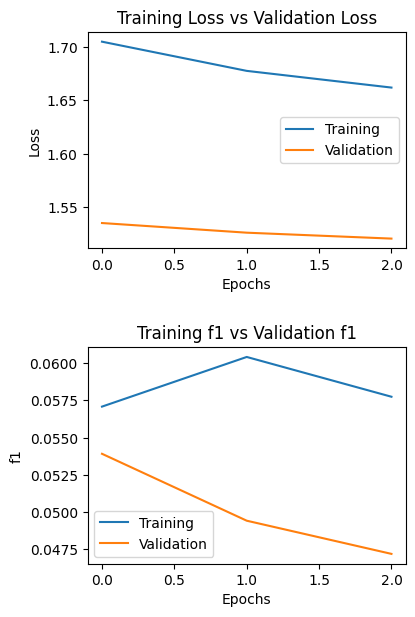

In [ ]:
%%time

# start time
print(datetime.now())

# run model
model, history, result = run_nn(num_feature=3, model_type="convolution", batch_size=64, epochs=3,
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0001), dropout=0.25,
           existing_model = None, metrics=['f1'])

# clear_output(wait=True)
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# gc.collect()

# end time
print(datetime.now())

##### With Cross Validation (Takes up too much RAM)

In [ ]:
# %%time

# model_types = ["convolution"]
# num_features = [3]
# i = 0

# for model_type, num_feature in itertools.product(model_types, num_features):

#     for j in range(5):
#       # Getting Input Data
#       if num_feature == 1:
#           input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

#       elif num_feature == 3:
#           input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

#       # Getting xy_data
#       xy_data = get_train_test_val_nn(input_data_,
#                             train_test_dict[f'train_{j+1}'],
#                             train_test_dict[f'test_{j+1}'])

#       # Get history and result
#       model_, history, result = fit_nn(xy_data, model_type, batch_size=32, epochs=3, loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0005))
#       model_list.append(model_)
#       histories.append(history)
#       results.append(result)

#       i += 1
#       clear_output(wait=True)

#       K.clear_session()
#       tf.compat.v1.reset_default_graph()
#       gc.collect()

#       print(f'Progress: {i}/{len(model_types)*len(num_features)*5}')
#       print(datetime.now())

NameError: ignored

##### Save Model

In [ ]:
# Save Model

# model name
now = datetime.now()
day, month, time = now.day, now.month, now.strftime("%H%M")
model_name = f"nn_51x51_{month}_{day}_{time}"

# save model
model.save(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras')

# save history
with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

# save notes about model
model_notes = 'num_feature=3, model_type="convolution", batch_size=64, epochs=500, \
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0001), dropout=0.25, \
           existing_model = None, metrics=["f1"]'

model_notes_row = [model_name, model_notes]

with open('/content/drive/My Drive/CapstoneProject/Models/model_notes.csv', 'a') as f:
  writer = writer(f)
  writer.writerow(model_notes_row)
  f.close()

In [ ]:
del model
del history
del result
gc.collect()

6669

In [ ]:
del model_notes
del model_notes_row
del writer
del model_name
gc.collect()

2076

In [ ]:
K.clear_session()
tf.compat.v1.reset_default_graph()
gc.collect()

0

In [ ]:
del sites_data
gc.collect()

0

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    sites_data: 28.8 MiB
                            _5: 28.8 MiB
               time_site_pairs:  6.8 MiB
     time_site_pairs_train_new:  6.8 MiB
         time_site_pairs_train:  5.8 MiB
                            _8:  5.8 MiB
          time_site_pairs_test:  1.7 MiB
                            _7:  1.7 MiB
                          _i11:  3.8 KiB
                          _i13:  2.3 KiB


#### Training From Existing Model

##### Load Model From File

In [ ]:
%%time

model_date = "6_29_1038"
model_name = f"nn_51x51_{model_date}"

# Load Model
loss = wbce_custom()
metric = f1
old_model = tf.keras.models.load_model(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

# Load History
with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', "rb") as file_pi:
    old_history = pickle.load(file_pi)

CPU times: user 192 ms, sys: 4.28 ms, total: 197 ms
Wall time: 549 ms


##### Training

In [ ]:
%%time
# start time
print(datetime.now())

# run model - change parameters as needed to match initial model!!!
model, history, result = run_nn(existing_model=old_model, dropout=0.25, epochs=5)

# Combine new history with old history
all_history = get_combined_history([old_history, history.history])

# end time
print(datetime.now())

2023-06-29 10:43:48.057748


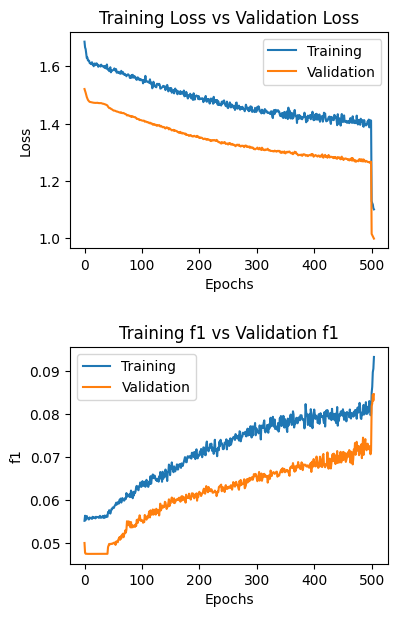

In [ ]:
plot_train_val_loss(all_history, metrics=['f1'])

In [ ]:
# Save Model

# model name
now = datetime.now()
day, month, time = now.day, now.month, now.strftime("%H%M")
model_name = f"nn_51x51_{month}_{day}_{time}"

# save model
model.save(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras')

# save history
with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

# save notes about model
model_notes = 'num_feature=3, model_type="convolution", batch_size=64, epochs=505, \
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0001), dropout=0.25, \
           existing_model = None, metrics=["f1"]'

model_notes_row = [model_name, model_notes]

with open('/content/drive/My Drive/CapstoneProject/Models/model_notes.csv', 'a') as f:
  writer = writer(f)
  writer.writerow(model_notes_row)
  f.close()

In [ ]:
input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

# Getting X_test and y_test
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

result = model.evaluate(X_test, y_test)

### Getting Results on Test Dataset

#### Loading Saved Model

In [ ]:
%%time

# model_date = "6_26_1757"
# model_name = f"nn_51x51_{model_date}"

model_names = [f"nn_51x51_{i}" for i in ['6_26_2221', '6_26_2310', '6_26_2343']]
old_models = []

for i in range(3):

  model_name = model_names[i]

  # Load Model
  loss = wbce_custom()
  metric = f1
  old_model = tf.keras.models.load_model(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

  # Load History
  with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', "rb") as file_pi:
      old_history = pickle.load(file_pi)

  old_models.append(old_model)

  print(f"Model: {model_name}. Epochs: {len(old_history['loss'])}")

Model: nn_51x51_6_26_2221. Epochs: 500
Model: nn_51x51_6_26_2310. Epochs: 500
Model: nn_51x51_6_26_2343. Epochs: 500
CPU times: user 510 ms, sys: 17.1 ms, total: 527 ms
Wall time: 4.23 s


#### Results Dataframe

In [ ]:
%%time
input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

# Getting X_test and y_test
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

results = []

for i in range(3):
  result = old_models[i].evaluate(X_test, y_test)
  results.append(result)

328/328 [==============================] - 2s 5ms/step - loss: nan - acc: 0.9739 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: nan
CPU times: user 12.7 s, sys: 8.8 s, total: 21.5 s
Wall time: 28.6 s


In [ ]:
results

[[1.0750255584716797,
  0.5807527303695679,
  0.7678231000900269,
  0.049366533756256104,
  0.8248175382614136,
  0.0863042026758194],
 [1.0782564878463745,
  0.45678895711898804,
  0.7616419792175293,
  0.04109589010477066,
  0.8868613243103027,
  0.07346949726343155],
 [nan, 0.973892331123352, 0.5, 0.0, 0.0, nan]]

In [ ]:
model_names = ['Dropout = 0', 'Dropout = 0.25', 'Dropout = 0.5']

df1 = pd.DataFrame(model_names, columns=['Sub-Model'])
df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
results_df_nn = pd.concat([df1, df2], axis=1)
results_df_nn['Model'] = ['Neural Network']*3
results_df_nn

,Sub-Model,loss,acc,AUC,Precision,Recall,f1,Model
0,Dropout = 0,1.075026,0.580753,0.767823,0.049367,0.824818,0.086304,Neural Network
1,Dropout = 0.25,1.078256,0.456789,0.761642,0.041096,0.886861,0.073469,Neural Network
2,Dropout = 0.5,NaN,0.973892,0.500000,0.000000,0.000000,NaN,Neural Network


In [ ]:
results_df_nn.to_csv("/content/drive/My Drive/CapstoneProject/Results/results_df_nn.csv")

In [ ]:
# model_names = []

# for model_type, num_feature, oversampling__ in itertools.product(model_types, num_features, oversampling_):
#     oversample = "Oversampling" if oversampling__ else "No Oversampling"
#     model_names.append(f'{model_type.capitalize()}, {num_feature} feature, {oversample}')

# df1 = pd.DataFrame(model_names, columns=['Sub-Model'])
# df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
# results_df_nn = pd.concat([df1, df2], axis=1)
# results_df_nn['Model'] = ['Neural Network']*8
# results_df_nn

In [ ]:
# model_names_string = model_names

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)

# for j in range(8):
#     ax = ([(k,i) for k in range(4) for i in range(2)])[j]
#     plot_train_val_loss(histories[j], model_names_string[j], ax)

# plt.suptitle('Training Loss vs Validation Loss')
# fig.supxlabel("Epochs")
# fig.supylabel("Loss")
# plt.show()

In [ ]:
# metric='f1'

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)

# for j in range(8):
#     ax = ([(k,i) for k in range(4) for i in range(2)])[j]
#     plot_train_val_metric(histories[j], model_names_string[j], ax, metric=metric)

# plt.suptitle(f'Training {metric} vs Validation {metric}')
# fig.supxlabel("Epochs")
# fig.supylabel(f"{metric}")
# plt.show()

# Final Results

In [ ]:
results_df_baseline = pd.read_csv("/content/drive/My Drive/CapstoneProject/Results/baseline")
results_df_rf = pd.read_csv("/content/drive/My Drive/CapstoneProject/Results/results_df_rf.csv")
results_df_nn = pd.read_csv("/content/drive/My Drive/CapstoneProject/Results/results_df_nn.csv")

In [ ]:
results_df_baseline.drop('Unnamed: 0', axis=1, inplace=True)
results_df_baseline.rename({'AUC_roc':'AUC'}, axis=1, inplace=True)
results_df_baseline['Sub-Model'] = 'Baseline'
results_df_baseline

,Model,AUC,Precision,Recall,f1,acc,Sub-Model
0,Baseline,0.505988,0.033859,0.036212,0.034879,0.955197,Baseline


In [ ]:
results_df_baseline_final = results_df_baseline[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
results_df_nn_final = results_df_nn[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
results_df_rf_final = results_df_rf[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
# results_df_lr_final = results_df_bc[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]

In [ ]:
pd.concat([results_df_baseline, results_df_nn_final, results_df_rf_final]).set_index(['Model', 'Sub-Model'])

AUC  Precision    Recall        f1  \
Model          Sub-Model                                                        
Baseline       Baseline               0.505988   0.033859  0.036212  0.034879   
Neural Network Dropout = 0            0.767823   0.049367  0.824818  0.086304   
               Dropout = 0.25         0.761642   0.041096  0.886861  0.073469   
               Dropout = 0.5          0.500000   0.000000  0.000000       NaN   
Random Forest  Fill NaN with mean df  0.781774   0.428571  0.075949  0.129032   
               Fill NaN with -10 df   0.781942   0.416667  0.063291  0.109890   

                                           acc  
Model          Sub-Model                        
Baseline       Baseline               0.955197  
Neural Network Dropout = 0            0.580753  
               Dropout = 0.25         0.456789  
               Dropout = 0.5          0.973892  
Random Forest  Fill NaN with mean df  0.977857  
               Fill NaN with -10 df   0.977857

# Window Size Comparison

## BC

In [ ]:
df_train = df_merged_mean.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_mean.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

In [ ]:
dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11']

performance = {}

for dim in dims:

    cols = [col for col in X_train.columns if dim in col]

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    X_train_scaled_new = scaler.fit_transform(X_train_new)
    X_test_scaled_new = scaler.transform(X_test_new)
    new_lg = lg_model(X_train_scaled_new, y_train)
    y_pred = new_lg.predict(X_test_scaled_new)

    performance[dim] = f1_score(y_test, y_pred)

In [ ]:
f1_scores = [i for i in performance.values()]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Random Forest, Fill NA value with mean')
plt.show()

## RF

In [ ]:
df_train = df_merged_mean.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_mean.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

In [ ]:
dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11']

performance = {}

for dim in dims:

    cols = [col for col in X_train.columns if dim in col]

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    performance[dim] = rf_result(X_train_new, y_train, X_test_new, y_test)

In [ ]:
f1_scores = [i['f1'] for i in performance.values()]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Random Forest, Fill NA value with mean')
plt.show()

## NN

In [ ]:
histories = []
results = []

In [ ]:
%%time


# Getting Input Data
input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

j = 0
for dim in [1,3,5,7,9,11]:

    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_,
                           time_site_pairs_train,
                           time_site_pairs_test,
                           dim=dim)

    # Get history and result
    _, history, result = fit_nn(xy_data, "convolution")
    histories.append(history)
    results.append(result)

    j += 1
    clear_output(wait=True)
    print(f'Progress: {j}/6')
    print(datetime.now())

In [ ]:
f1_scores = [i[5] for i in results]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Convolutional Neural Network, 3 feature, No Oversampling')
plt.show()

# Accuracy Comparison

## NN

In [ ]:
%%time
# convolution, 3 features, no oversampling

# Getting Input Data
input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]


# Getting xy_data
xy_data = get_train_test_val_nn(input_data_,
                       time_site_pairs_train,
                       time_site_pairs_test)

# Get history and result
model, history, result = fit_nn(xy_data, "convolution")

In [ ]:
test = pd.merge(time_site_pairs_test, input_data_, on=['time', 'site'])
test

In [ ]:
y_test_preds = model.predict(xy_data['X_test'])
test['preds'] = [1 if x >= 0.5 else 0 for x in y_test_preds]

In [ ]:
test['time'] = pd.to_datetime(test['time'])

In [ ]:
test.groupby(pd.Grouper(key='time', freq='M')).apply(lambda x: f1_score(x['riskLevelLabel'], x['preds']))